In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set the notebook parameters, the path to the key file and change working-directory to the root directory of the dataprocessing framework.

In [2]:
import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


Import all necessary packages.

In [3]:
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM

# Toolkit packets
import exot                       # Dataprocessing
import exot.experiment            # Experiment for execution
import exot.util                  # General utilities
import exot.layer                 # Data manipulation layers
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

# Plotting
from exot.plotting.experiment_plotter import *
from exot.plotting.run_plotter        import *

Tensorflow not available - excluding packets relying on it!


Parameters

In [4]:
NB_EXPERIMENT = "thermal-cc_capacity"

environments_to_execute = [
    "ARMv7",
    "ARMv8",
    "Haswell",
    "Sandy",
]

phases = {
    'ARMv7':['sweepARMv7'],
    'ARMv8':['sweepARMv8'],
    'Haswell':['sweepHaswell'],
    'Sandy':['sweepSandy'],
}

In [5]:
raise Exception("Are you sure?")

Exception: Are you sure?

# Generate Experiment
1. Load config

In [6]:
config = TOML.load(f"configurations/{NB_EXPERIMENT}.toml")
print(TOML.dumps(config))

name = "thermal-cc_capacity"
save_path = "./data"
backup_path = "./data/_backup"
experiment_exists_action = "update"

[EXPERIMENT]
type = "FrequencySweepExperiment"
channel = "ThermalCC"

[EXPERIMENT.GENERAL]
latency = 10
fan = true
governors = "userspace"
frequencies = "max"
sampling_period = 0.001
delay_after_spawn = 120.0
delay_after_auxiliary = 1.0
active_wait = false

[EXPERIMENT.PHASES.sweepARMv7]
length_seconds = 600
repetitions = 1
frequencies = []
signal = [ -1, 0,]

[EXPERIMENT.PHASES.sweepARMv8]
length_seconds = 600
repetitions = 1
frequencies = []
signal = [ -1, 0,]

[EXPERIMENT.PHASES.sweepSandy]
length_seconds = 120
repetitions = 1
frequencies = []
signal = [ -1, 0,]

[EXPERIMENT.PHASES.sweepHaswell]
length_seconds = 120
repetitions = 1
frequencies = []
signal = [ -1, 0,]

[EXPERIMENT.PHASES.test]
length_seconds = 10
repetitions = 1
frequencies = [ 1, 2,]
signal = [ -1, 0,]

[EXPERIMENT.LAYERS.rdp]
name = "CoreActivation"

[EXPERIMENT.LAYERS.io]
name = "TimeValue"

[EXPER

2. Get frequencies for sweeps

_The second stream should contain all frequencies that have a integer number of samples per period._

In [7]:
T_sampling_ms = config['EXPERIMENT']['GENERAL']['sampling_period'] * 1000
final_T_ms    = np.array([1])
for T_ms in np.arange(2, 2000, 1, dtype=int):
    remainder = np.mod(T_ms, T_sampling_ms)
    if((remainder == 0) and (abs((1 / (final_T_ms[-1]/1000) - (1 / (T_ms/1000))) >= 0.1))):
        final_T_ms = np.append(final_T_ms, T_ms)
frequencies = np.unique(np.round(1/(final_T_ms/1000),1))
frequencies[-1] = 0
frequencies.sort()
print("Found a total of " + str(len(frequencies)) + " frequencies to explore")
print(frequencies)
config['EXPERIMENT']['PHASES']['sweepHaswell']['frequencies'] = frequencies.tolist()

Found a total of 180 frequencies to explore
[  0.    0.6   0.7   0.8   0.9   1.    1.1   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.4   3.5   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3
   4.4   4.5   4.7   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.6   5.7   5.8   5.9   6.    6.1   6.2   6.4   6.5
   6.6   6.8   6.9   7.    7.1   7.2   7.4   7.5   7.6   7.7   7.8   7.9   8.1   8.2   8.3   8.5   8.6   8.8   8.9
   9.1   9.3   9.4   9.6   9.8  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.8  10.9  11.   11.1  11.2  11.4  11.5
  11.6  11.8  11.9  12.   12.2  12.3  12.5  12.7  12.8  13.   13.2  13.3  13.5  13.7  13.9  14.1  14.3  14.5  14.7
  14.9  15.2  15.4  15.6  15.9  16.1  16.4  16.7  16.9  17.2  17.5  17.9  18.2  18.5  18.9  19.2  19.6  20.   20.4
  20.8  21.3  21.7  22.2  22.7  23.3  23.8  24.4  25.   25.6  26.3  27.   27.8  28.6  29.4  30.3  31.2  32.3  33.3
  34.5  35.7  37.   38.5  40.   41.7

In [8]:
T_sampling_ms = config['EXPERIMENT']['GENERAL']['sampling_period'] * 1000
final_T_ms    = np.array([1])
for T_ms in np.arange(2, 2000, 1, dtype=int):
    remainder = np.mod(T_ms, T_sampling_ms)
    if((remainder == 0) and (abs((1 / (final_T_ms[-1]/1000) - (1 / (T_ms/1000))) >= 0.1))):
        final_T_ms = np.append(final_T_ms, T_ms)
frequencies = np.unique(np.round(1/(final_T_ms/1000),1))
frequencies[-1] = 0
frequencies.sort()
print("Found a total of " + str(len(frequencies)) + " frequencies to explore")
print(frequencies)
config['EXPERIMENT']['PHASES']['sweepSandy']['frequencies'] = frequencies.tolist()

Found a total of 180 frequencies to explore
[  0.    0.6   0.7   0.8   0.9   1.    1.1   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.4   3.5   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3
   4.4   4.5   4.7   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.6   5.7   5.8   5.9   6.    6.1   6.2   6.4   6.5
   6.6   6.8   6.9   7.    7.1   7.2   7.4   7.5   7.6   7.7   7.8   7.9   8.1   8.2   8.3   8.5   8.6   8.8   8.9
   9.1   9.3   9.4   9.6   9.8  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.8  10.9  11.   11.1  11.2  11.4  11.5
  11.6  11.8  11.9  12.   12.2  12.3  12.5  12.7  12.8  13.   13.2  13.3  13.5  13.7  13.9  14.1  14.3  14.5  14.7
  14.9  15.2  15.4  15.6  15.9  16.1  16.4  16.7  16.9  17.2  17.5  17.9  18.2  18.5  18.9  19.2  19.6  20.   20.4
  20.8  21.3  21.7  22.2  22.7  23.3  23.8  24.4  25.   25.6  26.3  27.   27.8  28.6  29.4  30.3  31.2  32.3  33.3
  34.5  35.7  37.   38.5  40.   41.7

In [9]:
T_sampling_ms = config['EXPERIMENT']['GENERAL']['ARMv8']['sampling_period'] * 1000
final_T_ms    = np.array([50])
for T_ms in np.arange(2, 2000, 1, dtype=int):
    remainder = np.mod(T_ms, T_sampling_ms)
    if((remainder == 0) and (abs((1 / (float(final_T_ms[-1])/1000.0)) - (1 / (float(T_ms)/1000.0))) >= 0.1)):
        final_T_ms = np.append(final_T_ms, T_ms)
frequencies = np.unique(np.round(1/(np.asarray(final_T_ms, dtype=float)/1000.0),1))
frequencies[-1] = 0
frequencies.sort()
print("Found a total of " + str(len(frequencies)) + " frequencies to explore")
print(frequencies)
config['EXPERIMENT']['PHASES']['sweepARMv8']['frequencies'] = frequencies.tolist()

Found a total of 78 frequencies to explore
[  0.    0.6   0.7   0.8   0.9   1.    1.1   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.6   2.7   2.8   2.9   3.    3.2   3.3   3.4   3.5   3.6   3.8   3.9   4.1   4.3   4.4   4.5   4.7   4.8
   4.9   5.    5.1   5.3   5.4   5.6   5.7   5.9   6.1   6.2   6.5   6.7   6.9   7.1   7.4   7.7   8.    8.3   8.7
   9.1   9.5  10.   10.5  11.1  11.8  12.5  13.3  14.3  15.4  16.7  18.2  20.   22.2  25.   28.6  33.3  40.   50.
  66.7 100. ]


In [10]:
T_sampling_ms = config['EXPERIMENT']['GENERAL']['ARMv7']['sampling_period'] * 1000
final_T_ms    = np.array([50])
for T_ms in np.arange(2, 2000, 1, dtype=int):
    remainder = np.mod(T_ms, T_sampling_ms)
    if((remainder == 0) and (abs((1 / (float(final_T_ms[-1])/1000.0)) - (1 / (float(T_ms)/1000.0))) >= 0.1)):
        final_T_ms = np.append(final_T_ms, T_ms)
frequencies = np.unique(np.round(1/(np.asarray(final_T_ms, dtype=float)/1000.0),1))
frequencies[-1] = 0
frequencies.sort()
print("Found a total of " + str(len(frequencies)) + " frequencies to explore")
print(frequencies)
config['EXPERIMENT']['PHASES']['sweepARMv7']['frequencies'] = frequencies.tolist()

Found a total of 78 frequencies to explore
[  0.    0.6   0.7   0.8   0.9   1.    1.1   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.6   2.7   2.8   2.9   3.    3.2   3.3   3.4   3.5   3.6   3.8   3.9   4.1   4.3   4.4   4.5   4.7   4.8
   4.9   5.    5.1   5.3   5.4   5.6   5.7   5.9   6.1   6.2   6.5   6.7   6.9   7.1   7.4   7.7   8.    8.3   8.7
   9.1   9.5  10.   10.5  11.1  11.8  12.5  13.3  14.3  15.4  16.7  18.2  20.   22.2  25.   28.6  33.3  40.   50.
  66.7 100. ]


3. Instantiate, generate and write the experiment

_Experiment factory will take the type and channel from the config._

In [11]:
raise Exception("Are you sure?")

Exception: Are you sure?

In [12]:
channel = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)

experiment.generate()
experiment.print_duration()
experiment.config.experiment_exists_action = "update"
experiment.write()

2020-04-11 21:47:09 :: bootstrapped layer 'rdp' with CoreActivation
2020-04-11 21:47:09 :: bootstrapped layer 'io' with TimeValue
2020-04-11 21:49:28 :: Estimated duration of a single repetition of the sweepARMv7 phase is 15:37:18
2020-04-11 21:49:28 :: Estimated duration of a single repetition of the sweepARMv8 phase is 15:37:18
2020-04-11 21:49:28 :: Estimated duration of a single repetition of the sweepSandy phase is 12:03:00
2020-04-11 21:49:28 :: Estimated duration of a single repetition of the sweepHaswell phase is 12:03:00
2020-04-11 21:49:28 :: Estimated duration of a single repetition of the test phase is 0:04:22
2020-04-11 21:49:28 :: This results in a total estimated duration of 2 days, 7:24:58 for all repetitions.


## Execute

Running `execute` will execute in all environments present in the configuration.

In [ ]:
raise Exception("Are you sure?")

In [ ]:
experiment.config.experiment_exists_action = "update"

for env in environments_to_execute:
    for phase in phases[env]:
        experiment.execute_in_environment(env, [phase], resume=True)

experiment.write()

In [ ]:
#%%debug --breakpoint /local/scratch/toolkit/datapro/exot/experiment/_base.py:1609
    
experiment.infer_execution_status(update_self=True, update_runs=True)
execution_status = experiment.execution_status

for _platform in phases:
    for phase, runs in execution_status.items():
        for run, statuses in runs.items():
            for platform, status in statuses:
                if _platform == platform and _platform in phase:
                    print(
                        "{}Phase: {:>20s} Run: {:3d} Platform: {:>8s} Status: {}".format(
                            "✓ " if any(status) else "✗ ", phase, run, platform, status
                        )
                    )

## Analyse

Deserialisation

In [13]:
path_to_serialised_experiment = PATH.Path("data/thermal-cc_capacity/_experiment.pickle")
experiment = FrequencySweepExperiment.read(path_to_serialised_experiment, diff_and_replace=True)

2020-04-12 10:41:03 :: unpicked an experiment instance <FrequencySweepExperiment at 0x7f167d2c8a90 with ThermalCC channel, configured>
2020-04-12 10:41:05 :: configs from pickle and directory differ at [{'path': ('save_path',), 'left': 'data', 'right': './data'}]
2020-04-12 10:41:06 :: bootstrapped layer 'rdp' with CoreActivation
2020-04-12 10:41:06 :: bootstrapped layer 'io' with TimeValue


If `experiment.spectra` are not *None* or empty, that means that the analysis has already been performed and the spectra generation step can be skipped. See the output below:

In [14]:
empty = experiment.spectra is None or getattr(experiment, "spectra", pd.DataFrame()).empty
print("Empty?", empty)

Empty? False


2020-04-12 10:41:36 :: \_ generating spectra for env: Haswell
2020-04-12 10:47:24 :: \_ generating spectra for env: Haswell
2020-04-12 10:53:00 :: \_ generating spectra for env: Haswell
2020-04-12 10:58:50 :: \_ generating spectra for env: Haswell
2020-04-12 11:04:32 :: \_ generating spectra for env: ARMv8
2020-04-12 11:07:42 :: \_ generating spectra for env: ARMv8
2020-04-12 11:10:53 :: \_ generating spectra for env: ARMv8
2020-04-12 11:13:58 :: \_ generating spectra for env: ARMv8
2020-04-12 11:16:56 :: \_ generating spectra for env: ARMv8
2020-04-12 11:20:03 :: \_ generating spectra for env: ARMv8
2020-04-12 11:23:28 :: \_ generating spectra for env: ARMv7
2020-04-12 11:26:35 :: \_ generating spectra for env: ARMv7
2020-04-12 11:29:47 :: \_ generating spectra for env: ARMv7
2020-04-12 11:33:09 :: \_ generating spectra for env: ARMv7
2020-04-12 11:36:19 :: \_ generating spectra for env: ARMv7
2020-04-12 11:39:34 :: \_ generating spectra for env: Sandy
2020-04-12 11:45:58 :: \_ genera

,host,core,C_wf,C_cwf
0,Haswell,0,97.211103,70.987537
1,Haswell,2,80.206904,56.061565
2,Haswell,4,469.576325,314.824961
3,Haswell,6,74.835716,53.622969
4,ARMv8,0,42.557585,30.822692
5,ARMv8,1,43.965882,31.515978
6,ARMv8,2,7.772172,6.579854
7,ARMv8,3,43.253832,31.135856
8,ARMv8,4,10.140697,0.000000
9,ARMv8,5,8.422902,7.029379


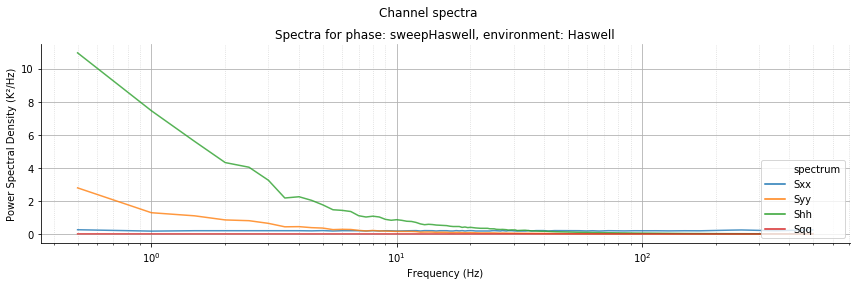

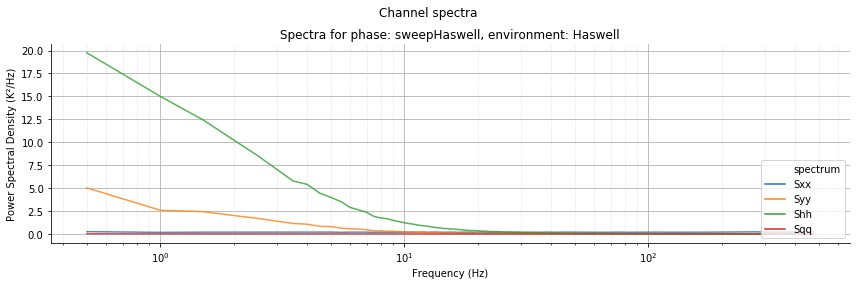

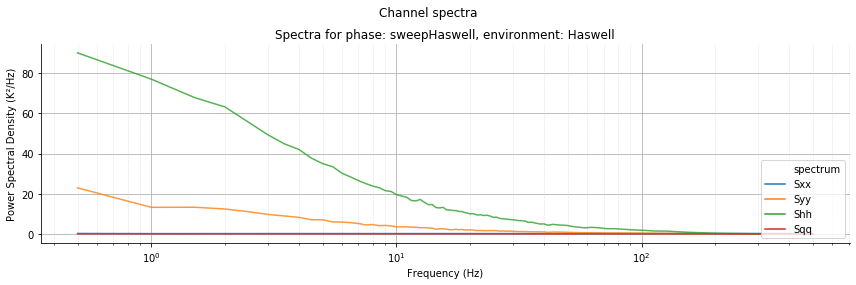

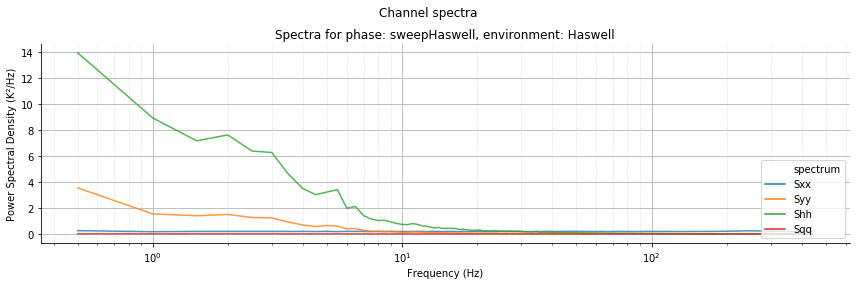

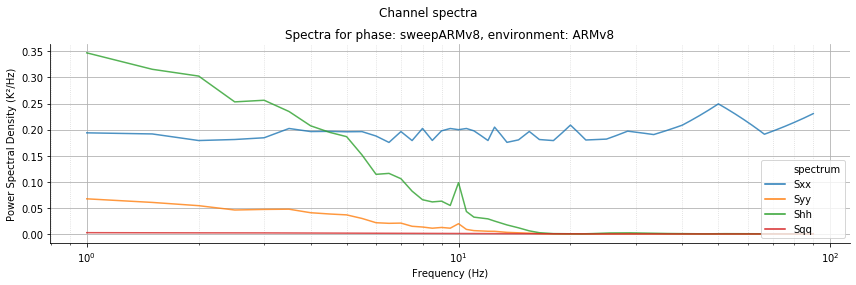

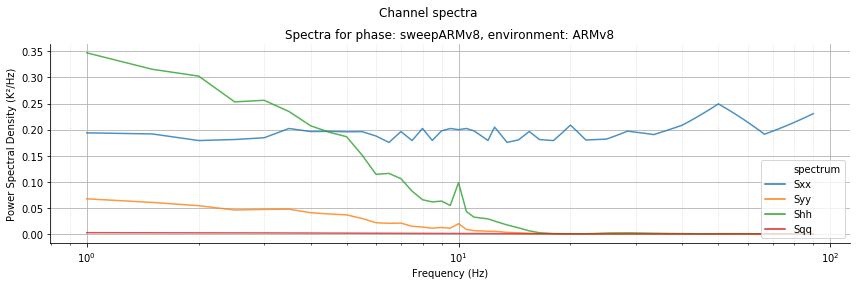

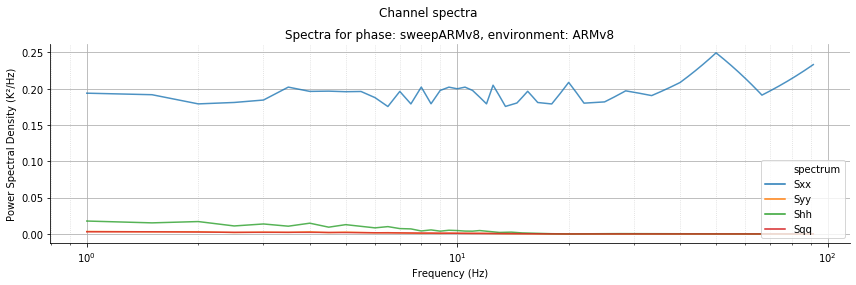

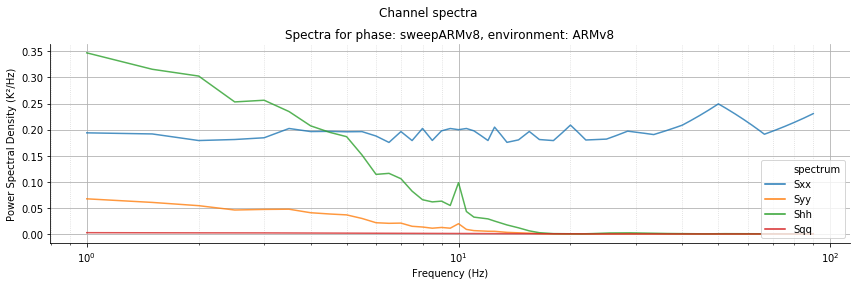

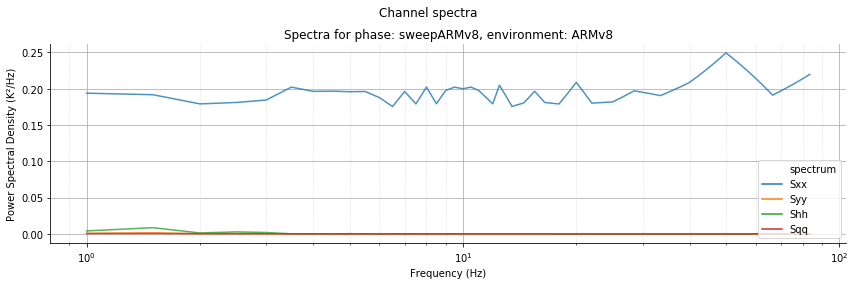

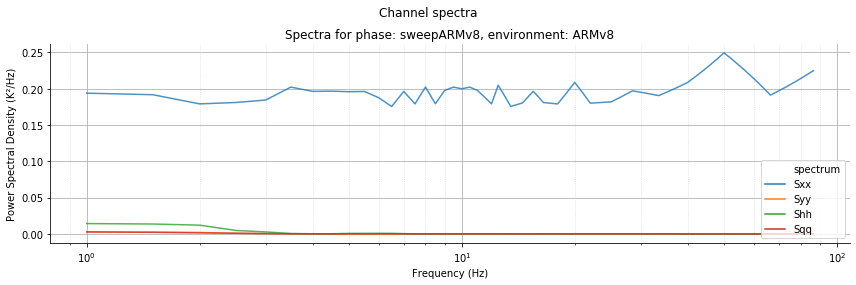

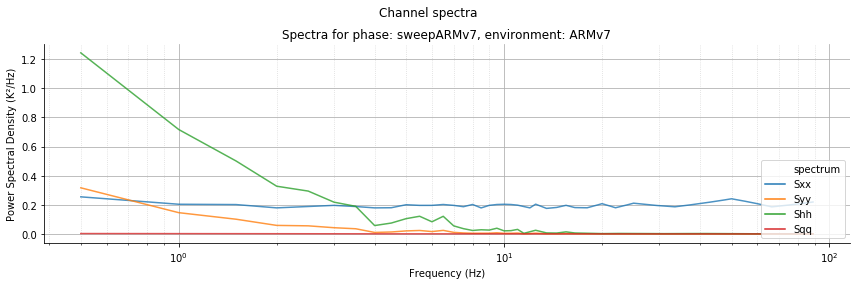

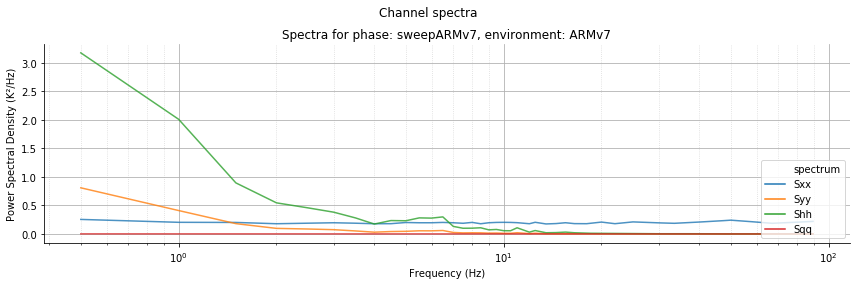

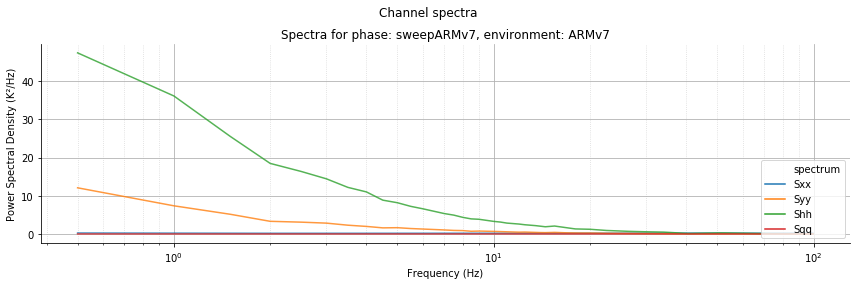

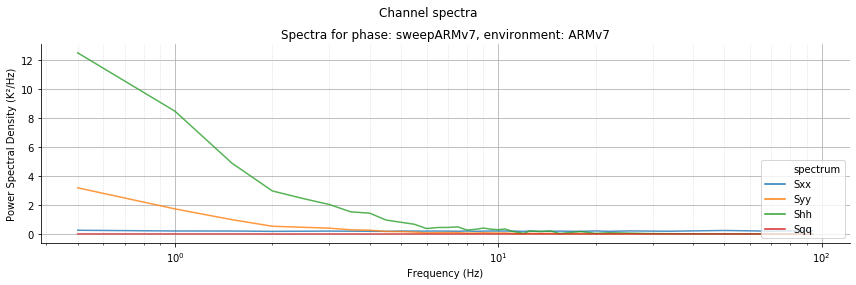

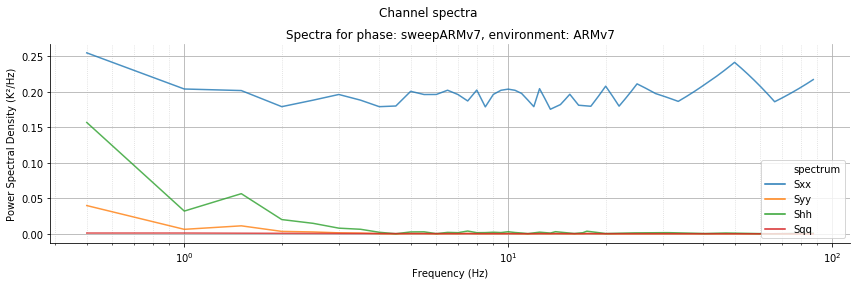

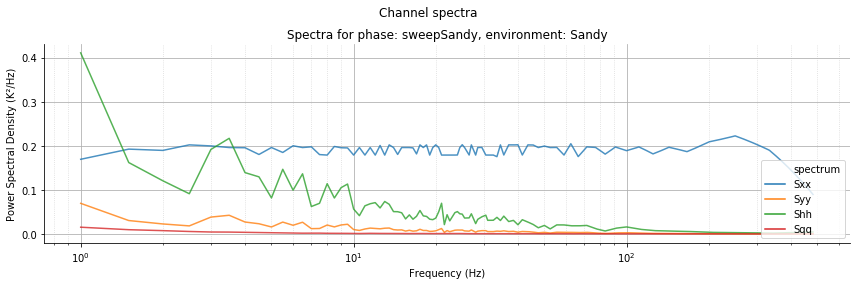

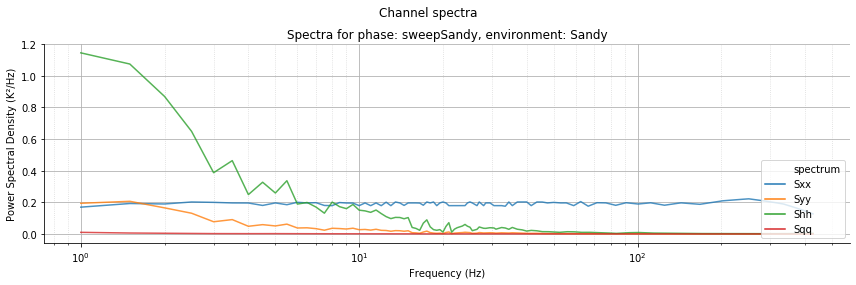

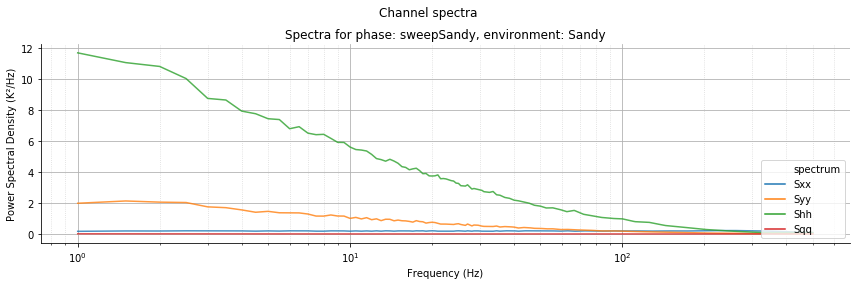

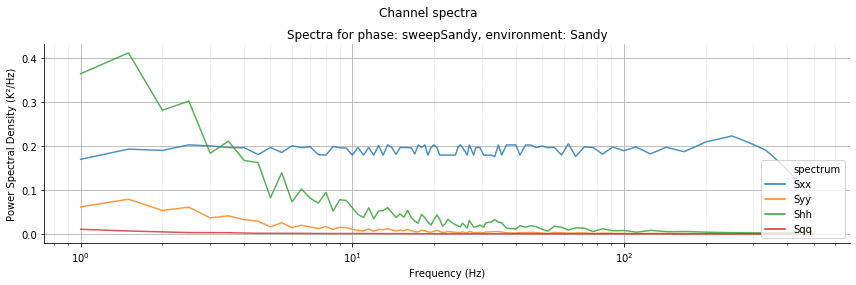

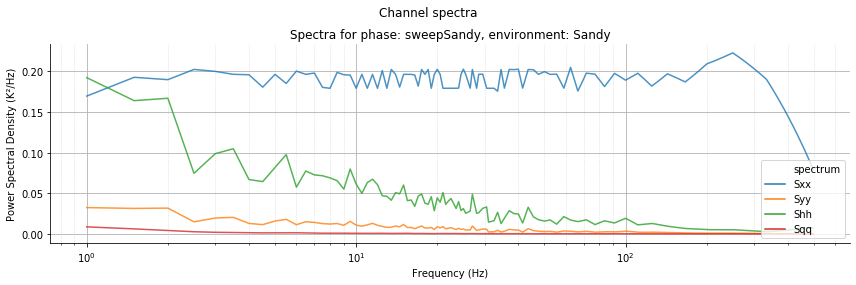

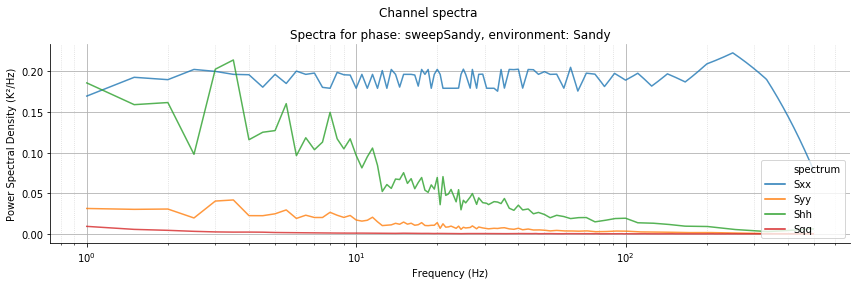

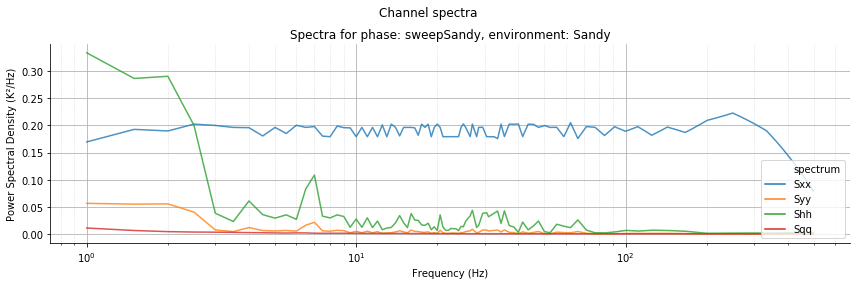

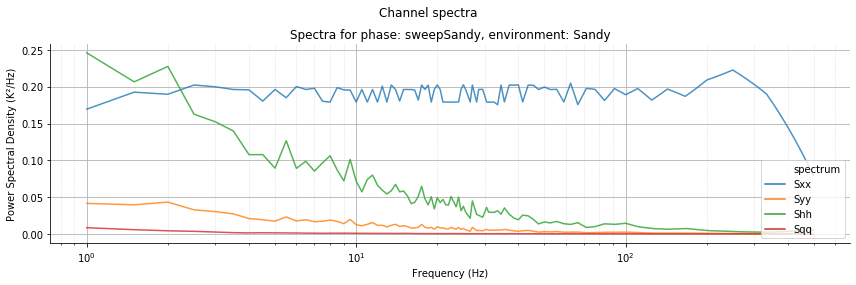

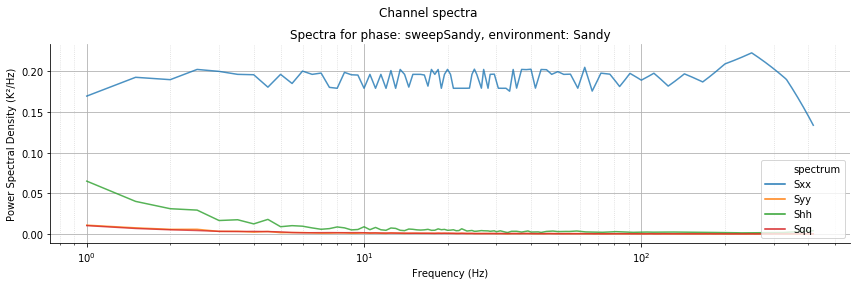

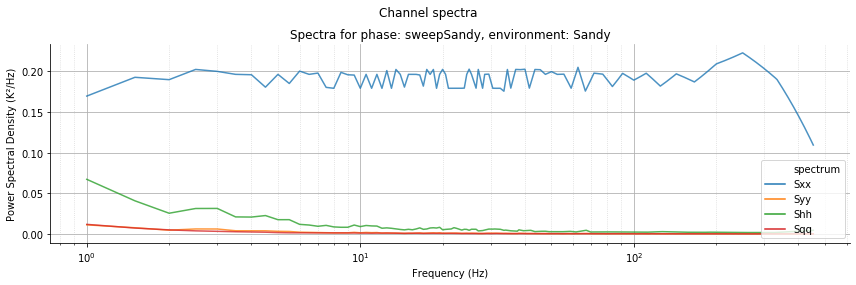

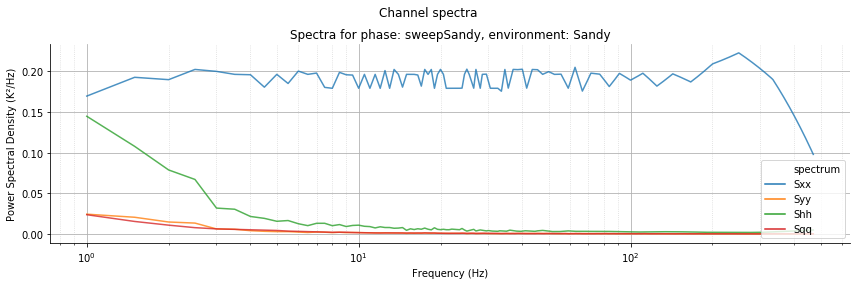

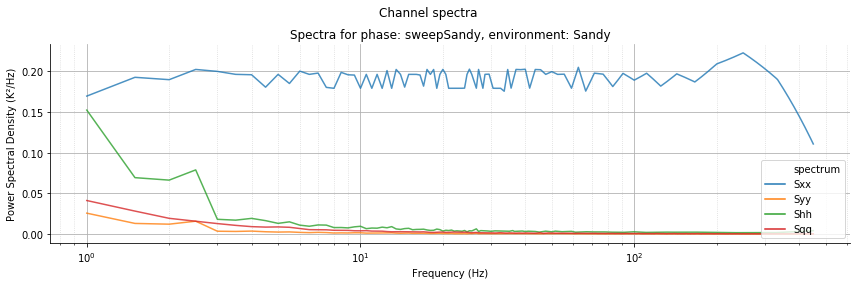

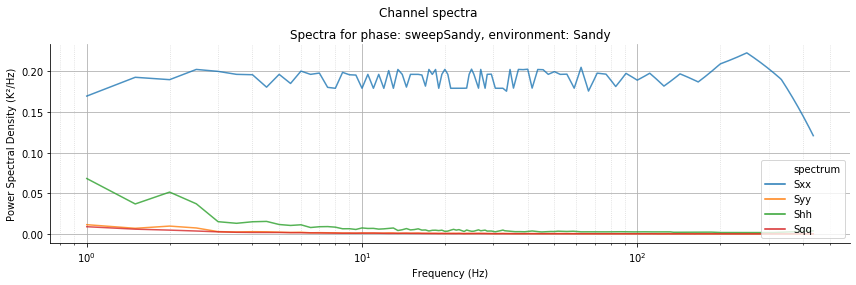

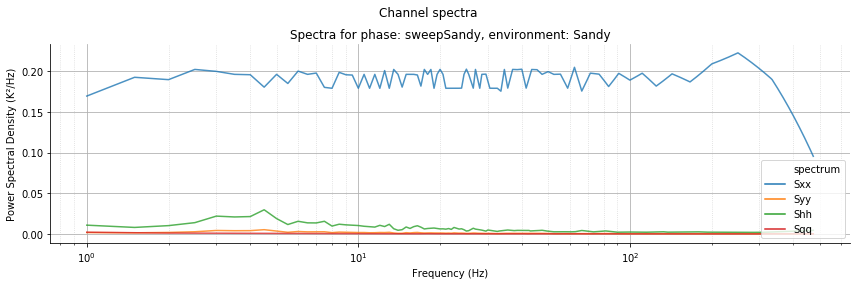

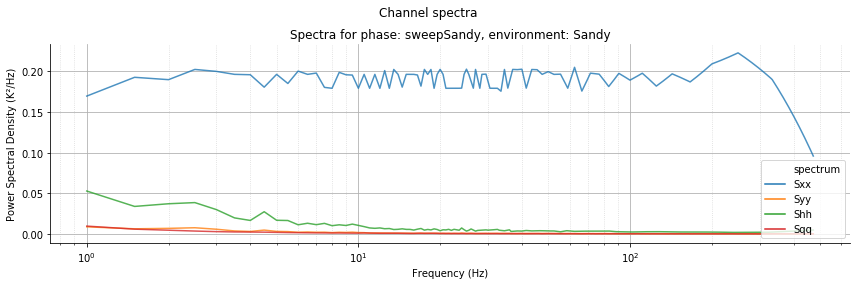

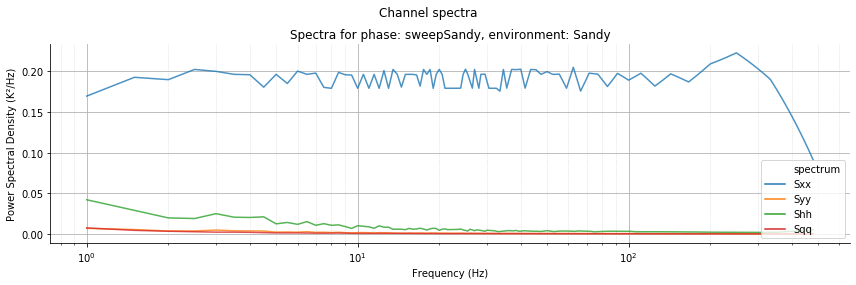

In [15]:
zones = {'Haswell': [0,2,4,6], 'ARMv8': list(range(6)), 'ARMv7': list(range(5)), 'Sandy':list(range(16))}

parameters = {"host":[], "core":[], "C_wf":[], "C_cwf":[]}
for env in ['Haswell', "ARMv8", "ARMv7", "Sandy"]:
    for phase in phases[env]:
        for zone in zones[env]:
            del experiment.spectra
            experiment.generate_spectra(
                phases=[phase],
                envs=[env],
                reps=[0],
                # other keyword args below
                window_size=400 if "ARMv" in env else 2000,
                io={
                    "matcher": [(exot.util.wrangle.Matcher(
                        "thermal",
                        "msr"   if (("Haswell" in env) or ("Sandy" in env)) else "sysfs",
                        ["core" if (("Haswell" in env) or ("Sandy" in env)) else "zone"],
                        [zone]), None)],
                }
            )
            Sqq = experiment.spectrum_as_matrix("Sqq", phase, env, 0)
            Shh = experiment.spectrum_as_matrix("Shh", phase, env, 0)
            Sxx = experiment.spectrum_as_matrix("Sxx", phase, env, 0)
            Syy = experiment.spectrum_as_matrix("Syy", phase, env, 0)
            p0  = wrangle.filter_data(
                    experiment.p0, phase=phase, environment=env, repetition=0)['p0'].values[0]

            for _spectrum in [("Sqq",Sqq), ("Shh",Shh), ("Sxx",Sxx), ("Syy",Syy)]:
                pd.DataFrame({"frequency:fft::Hz": _spectrum[1][:,0],
                              "power_spectral_density:K²/Hz": _spectrum[1][:,1]}).to_csv(
                    experiment.path.joinpath("{}_{}_core{}.dat".format(_spectrum[0],env,zone)),
                    sep=",",
                    encoding="utf-8",
                    index=False,
                )
            
            parameters['host'].append(env)
            parameters['core'].append(zone)
            parameters['C_wf'].append(capacity.classic_waterfilling(p0, Sqq, Shh))
            parameters['C_cwf'].append(capacity.constrained_waterfilling(p0, Sqq, Shh))
            with FrequencySweepExperimentPlotter(experiment) as plotter:
                plotter.plot_channel_spectra()
            
                
            for cur_run_tuple in experiment.phases[phase].items():
                cur_run = cur_run_tuple[1]
                if (
                    env == "Haswell" 
                    and zone == 2
                    and cur_run.config['frequency'] in [5.1,14.9,25.0,34.5]
                   ):
                    pd.DataFrame({"frequency:fft::Hz":cur_run.o_fspectrum.iloc[:,0],
                                   "power_spectral_density:K²/Hz":cur_run.o_fspectrum.iloc[:,-1]}).to_csv(
                            experiment.path.joinpath("Sxx_%s_core%i_%03i.dat" % (
                                                         env,zone,cur_run.config['frequency']*10)),
                            sep=",",
                            encoding="utf-8",
                            index=False,
                        )
                    pd.DataFrame({"frequency:fft::Hz":cur_run.i_fspectrum.iloc[:,0],
                                   "power_spectral_density:K²/Hz":cur_run.i_fspectrum.iloc[:,-1]}).to_csv(
                            experiment.path.joinpath("Syy_%s_core%i_%03i.dat" % (
                                                         env,zone,cur_run.config['frequency']*10)),
                            sep=",",
                            encoding="utf-8",
                            index=False,
                        )
                cur_run.save_ingestion_data()
                cur_run.remove_ingestion_data()
parameters = pd.DataFrame(parameters)
parameters.to_csv(
            experiment.path.joinpath("capacities.dat"),
            sep=" ",
            encoding="utf-8",
            index=False,
        )
parameters

In [16]:
assert experiment.config.experiment_exists_action == "update", "re-write only in update mode!"
experiment.write()